# Paso #1: IMPORTAR LIBRERÍAS

In [ ]:
!apt install unzip
!unzip Fotos\ TFM.zip
!unzip fotos\ procesadas.zip

In [ ]:
#Añadimos estas dos líneas adicionales para que uséis la misma versión que uso yo en el curso
!pip install tensorflow==2.12.0
!pip install keras==2.12.0

from google.colab.patches import cv2_imshow

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
from google.colab import files
uploaded  = files.upload() 

In [1]:
# Funciones y metodos reutilizables
def elem2dict(node):
    """
    Convert an xml.ElementTree node tree into a dict.
    """
    result = {}

    for element in node:
        key = element.tag
        if '}' in key:
            # Remove namespace prefix
            key = key.split('}')[1]
        
        if node.attrib:
            result['@attribs'] = dict(node.items())

        # Process element as tree element if the inner XML contains non-whitespace content
        if element.text and element.text.strip():
            value = element.text
        else:
            value = elem2dict(element)

        # Check if a node with this name at this depth was already found
        if key in result:
            if type(result[key]) is not list:
                # We've seen it before, but only once, we need to convert it to a list
                tempvalue = result[key].copy()
                result[key] = [tempvalue, value]
            else:
                # We've seen it at least once, it's already a list, just append the node's inner XML
                result[key].append(value)
        else:
            # First time we've seen it
            result[key] = value

    return result

def get_data_imgLabel(imgLabel):
    x = imgLabel["bndbox"]["xmin"]
    y = imgLabel["bndbox"]["ymin"]
    width = imgLabel["bndbox"]["xmax"]
    height = imgLabel["bndbox"]["ymax"]

    return x,y, width, height

# Funcion para redimensionar la imagen  a (512, 512)
# para redimensionar la imagen  a (512, 512)
def resize(x):
  return cv2.resize(x, dsize=(widthImage, heightImage), interpolation = cv2.INTER_AREA)

Cantidad de imágenes: Enfermas
650
Cantidad de imágenes: Sanas
650


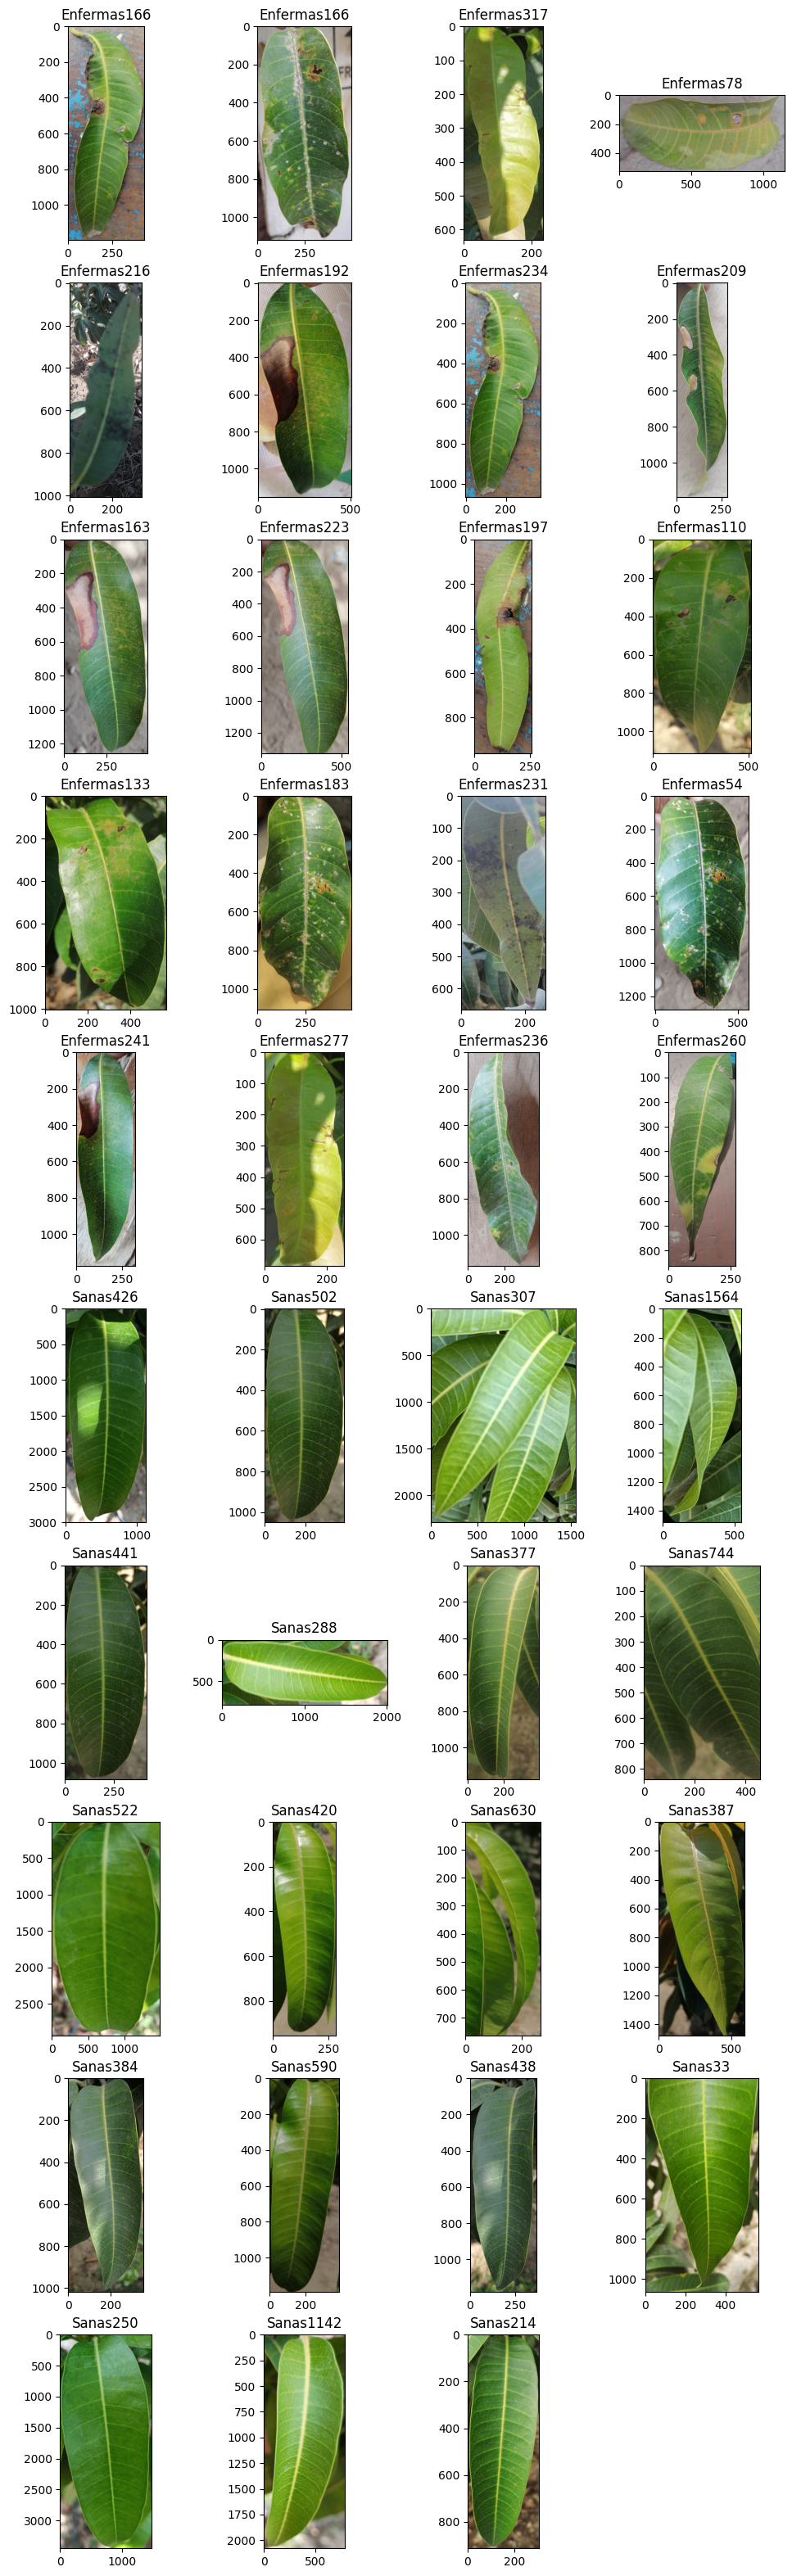

In [2]:
# Importamos los paquetes necesarios
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
from xml.etree import ElementTree as ET
import random

# Definimos variables generales

# Ruta de la data y capertas dentro de esta
dataPath = 'E:/proyecto tfm/tfm-leaves-computer-vision/Fotos TFM'
dataPathXML = 'E:/proyecto tfm/fotos procesadas'
typeLeavesList = os.listdir(dataPathXML)

widthImage = 512
heightImage = 512
quantitytoProcess = 600
counterSubPlot = 1

# data
labels = []
leavesData = []
labelCounter = 0

# Leemos la información de los Json en las carpetas, para obtener las coordenadas de las imagenes etiquetadas.
listCount = []
dataToProcess = []
fig = plt.figure(figsize=(12, 40))

for nameDir in typeLeavesList:
    leavePathXML = dataPathXML + '/' + nameDir
    leavePathImg = dataPath + '/' + nameDir

    # lista de archivos .json con las etiquetas de las imagenes
    listXML =  [f for f in os.listdir(leavePathXML) if f.endswith('.xml')]
    listXML = listXML[:650]

    countFilesXML = len([name for name in listXML ])
    print('Cantidad de imágenes:', nameDir)
    print(countFilesXML)

    sample20ListXML = random.sample(listXML, 20)

    # Cantidad de archivos a procesar
    listCount.append(countFilesXML)

    for fileXML in sample20ListXML:
        xmlParsed = ET.parse(leavePathXML + '/'+ fileXML).getroot()
        xmlDict = elem2dict(xmlParsed)
        imageName = xmlDict["filename"]

        if "object" not in xmlDict:
            continue
        if counterSubPlot>= 40:
            break

        objectImgLabel = xmlDict["object"]
        # Obtenemos la imagen completa
        image = cv2.imread(leavePathImg+'/'+ imageName)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
        if (type(objectImgLabel) == list):
            for imgLabel in objectImgLabel:

                x, y, width, height = get_data_imgLabel(imgLabel) 
                
                roi = image[int(y):int(height), int(x):int(width)]
                ax = fig.add_subplot(10, 4, counterSubPlot)

                plt.title(nameDir+str(x))
                plt.imshow(roi)
                counterSubPlot = counterSubPlot+ 1
        else:
           
            x, y, width, height = get_data_imgLabel(objectImgLabel) 
            
            roi = image[int(y):int(height), int(x):int(width)]
            ax = fig.add_subplot(10, 4, counterSubPlot)

            plt.title(nameDir+str(x))
            plt.imshow(roi)
            counterSubPlot = counterSubPlot+ 1

    for fileXML in listXML:

        xmlParsed = ET.parse(leavePathXML + '/'+ fileXML).getroot()
        xmlDict = elem2dict(xmlParsed)
        imageName = xmlDict["filename"]

        if "object" not in xmlDict:
            continue

        objectImgLabel = xmlDict["object"]

        # Obtenemos la imagen completa
        image = cv2.imread(leavePathImg+'/'+ imageName)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if (type(objectImgLabel) == list):
            for imgLabel in objectImgLabel:
                x, y, width, height = get_data_imgLabel(imgLabel)
                roi = image[int(y):int(height), int(x):int(width)]

                leafData = {
                    "filenameImg": imageName,
                    "filenameXML": fileXML,
                    "label" : labelCounter,
                    "roi": resize(roi)
                }
                dataToProcess.append(leafData)

        else:
            x, y, width, height = get_data_imgLabel(objectImgLabel)
            roi = image[int(y):int(height), int(x):int(width)]
            leafData = {
                "filenameImg": imageName,
                "filenameXML": fileXML,
                "label" : labelCounter,
                "roi": resize(roi)
            }
            dataToProcess.append(leafData)


    labelCounter = labelCounter + 1


In [9]:
# df = pd.DataFrame.from_records(dataToProcess )

# df

# df.to_csv("mydata.csv", index=False)
dataToProcess[0]
# json.dumps(dataToProcess)

# j = json.dumps({k: v.tolist() for k, v in dataToProcess[0].items()})

# # Back to dict
# a = {k: np.array(v) for k, v in json.loads(j).items()}
# print (a)
# with open("mydata.json", "w") as final:
#    json.dump( df.to_json(), final)


In [5]:
print('dataToProcess')
print(dataToProcess)

dataToProcess
[{'filenameImg': '329416264_4531784493611858_5862221435777685045_n.jpg', 'filenameXML': '329416264_4531784493611858_5862221435777685045_n.xml', 'label': 0, 'roi': array([[[146,  91,  71],
        [146,  91,  72],
        [147,  90,  74],
        ...,
        [187, 190, 201],
        [187, 190, 201],
        [186, 190, 201]],

       [[142,  86,  69],
        [142,  86,  69],
        [143,  85,  70],
        ...,
        [184, 190, 202],
        [184, 190, 202],
        [184, 190, 202]],

       [[137,  81,  66],
        [136,  80,  65],
        [137,  79,  67],
        ...,
        [181, 189, 200],
        [181, 189, 200],
        [181, 189, 200]],

       ...,

       [[169, 161, 158],
        [169, 161, 158],
        [167, 159, 156],
        ...,
        [133, 127, 127],
        [134, 128, 128],
        [134, 128, 128]],

       [[172, 163, 160],
        [172, 163, 160],
        [170, 162, 159],
        ...,
        [130, 124, 124],
        [131, 125, 125],
        [131

<Axes: >

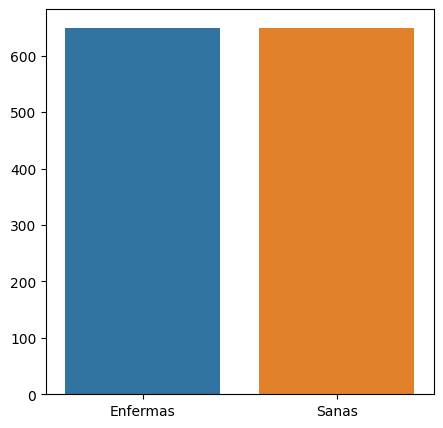

In [12]:
# Visualiacion de cantidad de imagenes por clasificación - Enfermas / Sanas
plt.figure(figsize = (5,5))
sns.barplot(x = typeLeavesList, y = listCount )

In [3]:
# cv2.destroyAllWindows()
newListSanas = filter(lambda x: x["label"] >= 0, dataToProcess)
newListEnfermas = filter(lambda x: x["label"] >= 1, dataToProcess)
print('Número de etiquetas 0: ', len(list(newListSanas)))
print('Número de etiquetas 1: ', len(list(newListEnfermas)))

Número de etiquetas 0:  1674
Número de etiquetas 1:  957


# Paso #2: VISUALIZACIÓN DE IMÁGENES

# Paso #3: PREPROCESADOR DE LAS IMÁGENES

In [4]:
# Dividir el dataframe en características y etiquetas para la clasificación
from keras.utils import to_categorical

# variables = dataToProcess[0].keys()
# df = pd.DataFrame([[getattr(i,j) for j in variables] for i in dataToProcess], columns = variables)

# print(df)

X = np.array([x["roi"] for x in dataToProcess])
y = to_categorical([x["label"] for x in dataToProcess] )

# # Visualizamos los pixeles de las imagenes
X[0]

array([[[146,  91,  71],
        [146,  91,  72],
        [147,  90,  74],
        ...,
        [187, 190, 201],
        [187, 190, 201],
        [186, 190, 201]],

       [[142,  86,  69],
        [142,  86,  69],
        [143,  85,  70],
        ...,
        [184, 190, 202],
        [184, 190, 202],
        [184, 190, 202]],

       [[137,  81,  66],
        [136,  80,  65],
        [137,  79,  67],
        ...,
        [181, 189, 200],
        [181, 189, 200],
        [181, 189, 200]],

       ...,

       [[169, 161, 158],
        [169, 161, 158],
        [167, 159, 156],
        ...,
        [133, 127, 127],
        [134, 128, 128],
        [134, 128, 128]],

       [[172, 163, 160],
        [172, 163, 160],
        [170, 162, 159],
        ...,
        [130, 124, 124],
        [131, 125, 125],
        [131, 125, 125]],

       [[170, 162, 159],
        [170, 162, 159],
        [171, 163, 160],
        ...,
        [127, 121, 121],
        [127, 121, 121],
        [127, 121, 121]]

In [5]:
# Visualizamos las etiquetas
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [6]:
# Revisando la dimensionalidad de X
X.shape

(1674, 512, 512, 3)

In [7]:
X = np.stack(X, axis = 0)
# aqui era uno, pero algo ha pasado y se cambio a 3
X = X.reshape(1674, 512, 512, 3)

print(X.shape, y.shape)

(1674, 512, 512, 3) (1674, 2)


In [8]:
# Dividir el dataframe en conjunto de entrenamiento, test y validación 

from sklearn.model_selection import train_test_split

# Obtenemos el conjunto de entrenamiento y el conjunto de Test
X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.4, shuffle = True)

# Del conjunto de Test, obtenemos una parte para el conjunto de validaciòn, el 50% del conjunto de Test
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)

In [9]:
print("Conjunto de validación")
print(X_val.shape, y_val.shape)
print("Conjunto de Test")
print(X_Test.shape, y_Test.shape)
print("Conjunto de Entrenamiento")
print(X_train.shape, y_train.shape)

Conjunto de validación
(335, 512, 512, 3) (335, 2)
Conjunto de Test
(335, 512, 512, 3) (335, 2)
Conjunto de Entrenamiento
(1004, 512, 512, 3) (1004, 2)


# Paso #4: NORMALIZACIÓN DE LOS DATOS Y PREPARACIÓN PARA EL ENTRENAMIENTO

In [10]:
# Pre Procesado de Imágenes 

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

X_train

array([[[[0.35686275, 0.37254902, 0.40784314],
         [0.35686275, 0.37254902, 0.40784314],
         [0.35686275, 0.37254902, 0.40784314],
         ...,
         [0.7372549 , 0.7254902 , 0.70980392],
         [0.78823529, 0.77647059, 0.75686275],
         [0.85098039, 0.83921569, 0.81960784]],

        [[0.34901961, 0.36470588, 0.4       ],
         [0.34117647, 0.35686275, 0.39215686],
         [0.3372549 , 0.35294118, 0.38823529],
         ...,
         [0.90196078, 0.89019608, 0.87058824],
         [0.94509804, 0.93333333, 0.91372549],
         [0.96862745, 0.95686275, 0.9372549 ]],

        [[0.36862745, 0.38431373, 0.41960784],
         [0.36470588, 0.38039216, 0.41568627],
         [0.36078431, 0.37647059, 0.41176471],
         ...,
         [0.96470588, 0.95294118, 0.92941176],
         [0.97647059, 0.96470588, 0.94117647],
         [0.98823529, 0.97647059, 0.95294118]],

        ...,

        [[0.29019608, 0.29019608, 0.32156863],
         [0.29803922, 0.29803922, 0.32941176]

# Paso #3: AUMENTACIÓN DE LAS IMÁGENES

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [1.1, 1.35],
    fill_mode = "nearest")


# TAREA #6: CONSTRUIR UN MODELO DE DEEP LEARNING(CNN) DE RESTNET(RED RESIDUAL)

In [21]:
# Se define a nivel de código, el bloque de capa red residual (RESTNET) 
# Lo usaremos luego en a la arquitectura principal del modelo

def res_block(X, filter, stage):

  # Bloque Convolucional
  X_copy = X

  f1 , f2, f3 = filter

  # Camino Principal
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Camino Corto
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # Añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Bloque de Identidad 1
  X_copy = X


  # Camino Principal
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # Añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Bloque de Identidad 2
  X_copy = X


  # Camino Principal
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # Añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [26]:
# Se define a nivel de código, el bloque de capa red residual (RESTNET) 
# Lo usaremos luego en a la arquitectura principal del modelo

def res_block_v2(X, filter, stage):

  # Bloque Convolucional
  X_copy = X

  f1 , f2, f3 = filter

  # Camino Principal
  X = layers.Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = layers.MaxPool2D((2,2))(X)
  X = layers.BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = layers.Activation('relu')(X) 

  X = layers.Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = layers.BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = layers.Activation('relu')(X) 

  X = layers.Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = layers.BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Camino Corto
  X_copy = layers.Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = layers.MaxPool2D((2,2))(X_copy)
  X_copy = layers.BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # Añadir
  X = layers.Add()([X,X_copy])
  X = layers.Activation('relu')(X)

  # Bloque de Identidad 1
  X_copy = X


  # Camino Principal
  X = layers.Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = layers.BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = layers.Activation('relu')(X) 

  X = layers.Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = layers.BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = layers.Activation('relu')(X) 

  X = layers.Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = layers.BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # Añadir
  X = layers.Add()([X,X_copy])
  X = layers.Activation('relu')(X)

  # Bloque de Identidad 2
  X_copy = X


  # Camino Principal
  X = layers.Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = layers.BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = layers.Activation('relu')(X) 

  X = layers.Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = layers.BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = layers.Activation('relu')(X) 

  X = layers.Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = layers.BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # Añadir
  X = layers.Add()([X,X_copy])
  X = layers.Activation('relu')(X)

  return X

In [33]:
# Arquietectura principal para CNN con RestNet

# Debo usar pixeles mas grandes como 512 x 512
input_shape = (512, 512, 3)

# Tamaño del tensor de entrada
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - Fase
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - Fase
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - Fase
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - Fase
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Capa Final
X = Flatten()(X)
X = Dense(2, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model_clasification_leaves = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_clasification_leaves.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 1,227,906
Trainable params: 1,219,330
Non-trainable params: 8,576
__________________________________________________________________________________________________


In [43]:
# Arquietectura principal para CNN con RestNet

# Debo usar pixeles mas grandes como 512 x 512
input_shape_v2 = (512, 512, 3)

# Tamaño del tensor de entrada
X_input2 = keras.Input(input_shape_v2)

# Zero-padding
X = layers.ZeroPadding2D((3, 3))(X_input2)

# 1 - Fase
X = layers.Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = layers.BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = layers.Activation('relu')(X)
X = layers.MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - Fase
X = res_block_v2(X, filter= [64, 64, 256], stage= 2)

# 3 - Fase
X = res_block_v2(X, filter= [128, 128, 512], stage= 3)

# 4 - Fase
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = layers.AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Capa Final
X = layers.Flatten()(X)
X = layers.Dense(2, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model_clasification_leaves = keras.Model( inputs= X_input2, outputs = X, name = 'Resnet18')

model_clasification_leaves.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 518, 518, 3)  0          ['input_11[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 256, 64  9472        ['zero_padding2d_10[0][0]']      
                                )                                                          

In [44]:
# Entrenar la red 
model_clasification_leaves.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# categorical_crossentropy


In [47]:
# Usamos la parada temprana para salir del entenamiento si el error de validación
# no decrece después de cierto número de epochs (paciencia) 
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

# Guardamos el mejor modelo con menor error de validación
checkpointer = ModelCheckpoint(
    filepath = "Leaves_Clasification_weights.hdf5", 
    verbose = 1, 
    save_best_only=True, 
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max')

In [48]:
print("Conjunto de Entrenamiento")
print(X_train.shape, y_train.shape)

Conjunto de Entrenamiento
(1004, 512, 512, 3) (1004, 2)


In [49]:
history = model_clasification_leaves.fit(train_datagen.flow(X_train, y_train, batch_size=4),
	validation_data=(X_val, y_val), steps_per_epoch=2,
	epochs= 4, callbacks=[checkpointer, earlystopping])

Epoch 1/4
2/2 [==============================] - ETA: 0s - loss: 2.6527 - accuracy: 0.6250 
Epoch 1: val_accuracy improved from -inf to 0.39701, saving model to Leaves_Clasification_weights.hdf5
2/2 [==============================] - 97s 73s/step - loss: 2.6527 - accuracy: 0.6250 - val_loss: 0.7133 - val_accuracy: 0.3970
Epoch 2/4
2/2 [==============================] - ETA: 0s - loss: 2.7390 - accuracy: 0.2500
Epoch 2: val_accuracy improved from 0.39701 to 0.40000, saving model to Leaves_Clasification_weights.hdf5
2/2 [==============================] - 42s 37s/step - loss: 2.7390 - accuracy: 0.2500 - val_loss: 0.8058 - val_accuracy: 0.4000
Epoch 3/4
2/2 [==============================] - ETA: 0s - loss: 1.2456 - accuracy: 0.6250
Epoch 3: val_accuracy did not improve from 0.40000
2/2 [==============================] - 44s 39s/step - loss: 1.2456 - accuracy: 0.6250 - val_loss: 0.9726 - val_accuracy: 0.4000
Epoch 4/4
2/2 [==============================] - ETA: 0s - loss: 34.6978 - accurac

In [50]:
predictions = model_clasification_leaves.predict(X_Test)

11/11 [==============================] - 32s 2s/step


In [52]:
model_clasification_leaves.save('leaf_model.h5')

In [38]:
# Guardar la arquitectura del modelo en un JSON para su futuro uso 

# model_json = model_clasification_leaves.to_json()
print(model_clasification_leaves)
# with open("Leaves_Clasification_model.json","w") as json_file:
  # json_file.write(model_json)

# Paso #16: EVALUAR LA EFICACIA DEL MODELO CLASIFICACIÓN

In [53]:
# with open('emotion.json', 'r') as json_file:
#     json_savedModel= json_file.read()
    
# Cargamos la arquitectura del modelo
model_clasification_leaves = tf.keras.models.load_model('leaf_model.h5')
# model_clasification_leaves.load_weights('Leaves_Clasification_weights.hdf5')
model_clasification_leaves.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [54]:
score = model_clasification_leaves.evaluate(X_Test, y_Test)
print('Accuracy en la fase de Test: {}'.format(score[1]))

11/11 [==============================] - 31s 2s/step - loss: 0.9917 - accuracy: 0.4627
Accuracy en la fase de Test: 0.46268656849861145


In [ ]:
history.history.keys()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Accuracy en el Entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Accuracy en la Validación')
plt.title('ACCURACY')
plt.legend()

In [ ]:
plt.plot(epochs, loss, 'ro', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.title('LOSS')
plt.legend()

In [ ]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

In [ ]:
y_true.shape

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

# Paso #16: EVALUAR EL MODELO DE CLASIFICACIÓN (MATRIZ DE CONFUSIÓN, ACIERTO, PRECISIÓN Y RECUPERACIÓN)